<a href="https://colab.research.google.com/github/ilitteri/7506-Datos/blob/main/tp3_parte2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install --upgrade --force-reinstall 'scikit-learn'

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 24.8 MB 1.7 MB/s 
     |████████████████████████████████| 306 kB 33.4 MB/s 
     |████████████████████████████████| 38.1 MB 1.4 MB/s 
     |████████████████████████████████| 15.7 MB 167 kB/s 
  Attempting uninstall: numpy
    Found existing installation: numpy 1.21.6
    Uninstalling numpy-1.21.6:
      Successfully uninstalled numpy-1.21.6
  Attempting uninstall: threadpoolctl
    Found existing installation: threadpoolctl 3.1.0
    Uninstalling threadpoolctl-3.1.0:
      Successfully uninstalled threadpoolctl-3.1.0
  Attempting uninstall: scipy
    Found existing installation: scipy 1.4.1
    Uninstalling scipy-1.4.1:
      Successfully uninstalled scipy-1.4.1
  Attempting uninstall: joblib
    Found existing installation: joblib 1.1.0
    Uninstalling joblib-1.1.0:
      Successfully uninstalled joblib-1.1.0
  Attempting uninstall: scikit-learn
 

In [ ]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, MultiLabelBinarizer
from sklearn.feature_extraction.text import CountVectorizer

SEED = 7

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Funciones auxiliares

def drop_features(train, valid, dropped_features, *features):
    dropped_features.update(features)
    for feature in features:
        if feature == None:
            continue
        train = train.drop(feature, axis=1)
        valid = valid.drop(feature, axis=1)
    return train, valid

def fit_and_score(model, x_train, x_valid, y_train, y_valid):
    model.fit(x_train, y_train)
    return roc_auc_score(y_valid, model.predict_proba(x_valid)[:,1])

def encode(feature, withEncoder, onTrain, onValid, mappingFeature=None):
    if mappingFeature == None:
        return withEncoder[feature].fit_transform(onTrain[feature]), withEncoder[feature].transform(onValid[feature])
    return withEncoder[feature].fit_transform(onTrain[feature].mappingFeature()), withEncoder[feature].transform(onValid[feature].mappingFeature())

# Feature Engineering

In [ ]:
train = pd.read_parquet('/content/drive/MyDrive/train')

In [ ]:
train = train.sort_values('timedelta', ascending=False)

## Test Splitting

In [ ]:
x_train, x_valid, y_train, y_valid = train_test_split(
    train, 
    train[['popular']], 
    test_size=0.2, 
    random_state=SEED
)

## Encoding

In [ ]:
encoders = {}

### surprise1 encoding

In [ ]:
surprise1_mean_encoding = lambda dataset: dataset.groupby('surprise1')['is_weekend'].mean().to_dict()

x_train['surprise1'] = x_train['surprise1'].map(surprise1_mean_encoding(x_train))
x_valid['surprise1'] = x_valid['surprise1'].map(surprise1_mean_encoding(x_valid))

### suprise2 encoding

In [ ]:
encoders['surprise2'] = MultiLabelBinarizer()

x_train.surprise2 = x_train.surprise2.map(lambda x: 'unknown' if x == '' else x)
x_valid.surprise2 = x_valid.surprise2.map(lambda x: 'unknown' if x == '' else x)

x_train.surprise2 = x_train.surprise2.map(lambda x: x.split(','))
x_valid.surprise2 = x_valid.surprise2.map(lambda x: x.split(','))

encoded_x_train_surprise2, encoded_x_valid_surprise2 = encode('surprise2', encoders, x_train, x_valid)

surprise2_x_train_emotions = pd.DataFrame(encoded_x_train_surprise2, columns=encoders['surprise2'].classes_)
surprise2_x_valid_emotions = pd.DataFrame(encoded_x_valid_surprise2, columns=encoders['surprise2'].classes_)

x_train.surprise2 = encoded_x_train_surprise2
x_valid.surprise2 = encoded_x_valid_surprise2

x_train = pd.concat([x_train.reset_index(), surprise2_x_train_emotions.reset_index()], axis=1)
x_valid = pd.concat([x_valid.reset_index(), surprise2_x_valid_emotions.reset_index()], axis=1)

### popular encoding

In [ ]:
encoders['popular'] = LabelEncoder()

encoded_y_train, encoded_y_valid = encode(
    feature='popular', withEncoder=encoders,
    onTrain=y_train, onValid=y_valid
)

y_train['popular'] = encoded_y_train
y_valid['popular'] = encoded_y_valid

### content encoding

In [ ]:
encoders['content'] = CountVectorizer(analyzer='word', stop_words='english', max_features=10)

x_train['content'] = x_train['content'].fillna('')
x_valid['content'] = x_valid['content'].fillna('')

vectorized_x_train_content = encoders['content'].fit_transform(x_train['content'].tolist()).toarray()
vectorized_x_valid_content = encoders['content'].transform(x_valid['content'].tolist()).toarray()

x_train_content_word_count = pd.DataFrame(vectorized_x_train_content, columns=encoders['content'].get_feature_names())
x_valid_content_word_count = pd.DataFrame(vectorized_x_valid_content, columns=encoders['content'].get_feature_names())

x_train['content'] = vectorized_x_train_content
x_valid['content'] = vectorized_x_valid_content

x_train = pd.concat([x_train.reset_index(), x_train_content_word_count.reset_index()], axis=1)
x_valid = pd.concat([x_valid.reset_index(), x_valid_content_word_count.reset_index()], axis=1)

In [ ]:
features_eliminadas = set()

In [ ]:
x_train, x_valid = drop_features(
    x_train, x_valid, features_eliminadas,
    'url', 'popular', 'shares', 'timedelta', 'index', 'level_0'
)

### Null imputation

In [ ]:
x_train = x_train.fillna(0.0)
x_valid = x_valid.fillna(0.0)

# Modelo

### Baseline -> Score: 0.6890949409053888

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import MinMaxScaler

logistic_regression = LogisticRegression(random_state=SEED, n_jobs=-1, solver='saga', warm_start=True)
scaler = MinMaxScaler()

fit_and_score(logistic_regression, scaler.fit_transform(x_train), scaler.transform(x_valid), y_train.popular, y_valid.popular)

0.6890949409053888

## Búsqueda de hiperparámetros

In [ ]:
logistic_regression_hyperparameters = {
    'penalty': ["l1", "l2", "elasticnet", "none"],
    'dual': [True, False],
    'tol': [1e-4],
    'C': [1.0, .8, .6, .4, .2],
    'fit_intercept': [True, False],
    'class_weight': [None, 'balanced'],
    'max_iter': [100, 200],
    'multi_class': ["auto", "ovr", "multinomial"],
    'l1_ratio': [0.1, 0.5, 0.9],
}

### Iteración 1: RandomizedSearchCV -> Score: 0.6951611898781476

In [ ]:
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV

rscv = RandomizedSearchCV(
    estimator=logistic_regression,
    param_distributions=logistic_regression_hyperparameters,
    cv=3, n_iter=50,
    scoring = 'roc_auc', n_jobs=-1,
    verbose = 5, 
    random_state=SEED
)

rscv.fit(x_train ,y_train.popular)
rscv.best_params_

Fitting 3 folds for each of 50 candidates, totalling 150 fits


{'C': 1.0,
 'class_weight': 'balanced',
 'dual': False,
 'fit_intercept': False,
 'l1_ratio': 0.1,
 'max_iter': 200,
 'multi_class': 'multinomial',
 'penalty': 'elasticnet',
 'tol': 0.0001}

In [ ]:
lr = LogisticRegression(
    C=1.0,
    class_weight='balanced',
    dual=False,
    fit_intercept=False,
    l1_ratio=0.1,
    max_iter=200,
    multi_class='multinomial',
    penalty='elasticnet',
    tol=0.0001,
    random_state=SEED, 
    n_jobs=-1, 
    solver='saga', 
    warm_start=True
)
fit_and_score(lr, scaler.fit_transform(x_train), scaler.transform(x_valid), y_train.popular, y_valid.popular)


0.6951611898781476

### Iteración 2: GridSearchCV -> Score: 0.6988522982730137

In [ ]:
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV

rscv = GridSearchCV(
    estimator=lr,
    param_grid=logistic_regression_hyperparameters,
    scoring = 'roc_auc', n_jobs=-1,
    verbose = 5,
    cv=2
)

rscv.fit(x_train ,y_train.popular)
rscv.best_params_

Fitting 2 folds for each of 2880 candidates, totalling 5760 fits


{'C': 0.8,
 'class_weight': 'balanced',
 'dual': False,
 'fit_intercept': True,
 'l1_ratio': 0.1,
 'max_iter': 200,
 'multi_class': 'multinomial',
 'penalty': 'l1',
 'tol': 0.0001}

In [ ]:
lr2 = LogisticRegression(
    C=0.8,
    class_weight='balanced',
    dual=False,
    fit_intercept=True,
    l1_ratio=0.1,
    max_iter=200,
    multi_class='multinomial',
    penalty='l1',
    tol=0.0001,
    random_state=SEED, 
    n_jobs=-1, 
    solver='saga', 
    warm_start=True
)
fit_and_score(lr2, scaler.fit_transform(x_train), scaler.transform(x_valid), y_train.popular, y_valid.popular)

0.6988522982730137

## Modelo final

In [ ]:
import sklearn.linear_model as lm

logistic_regression_final = lm.LogisticRegression(
    C=0.8,
    class_weight='balanced',
    dual=False,
    fit_intercept=True,
    l1_ratio=0.1,
    max_iter=200,
    multi_class='multinomial',
    penalty='l1',
    tol=0.0001,
    random_state=SEED, 
    n_jobs=-1, 
    solver='saga', 
    warm_start=True
)
fit_and_score(logistic_regression_final, scaler.fit_transform(x_train), scaler.transform(x_valid), y_train.popular, y_valid.popular)

0.6988522982730137

# Features más importantes

<BarContainer object of 87 artists>

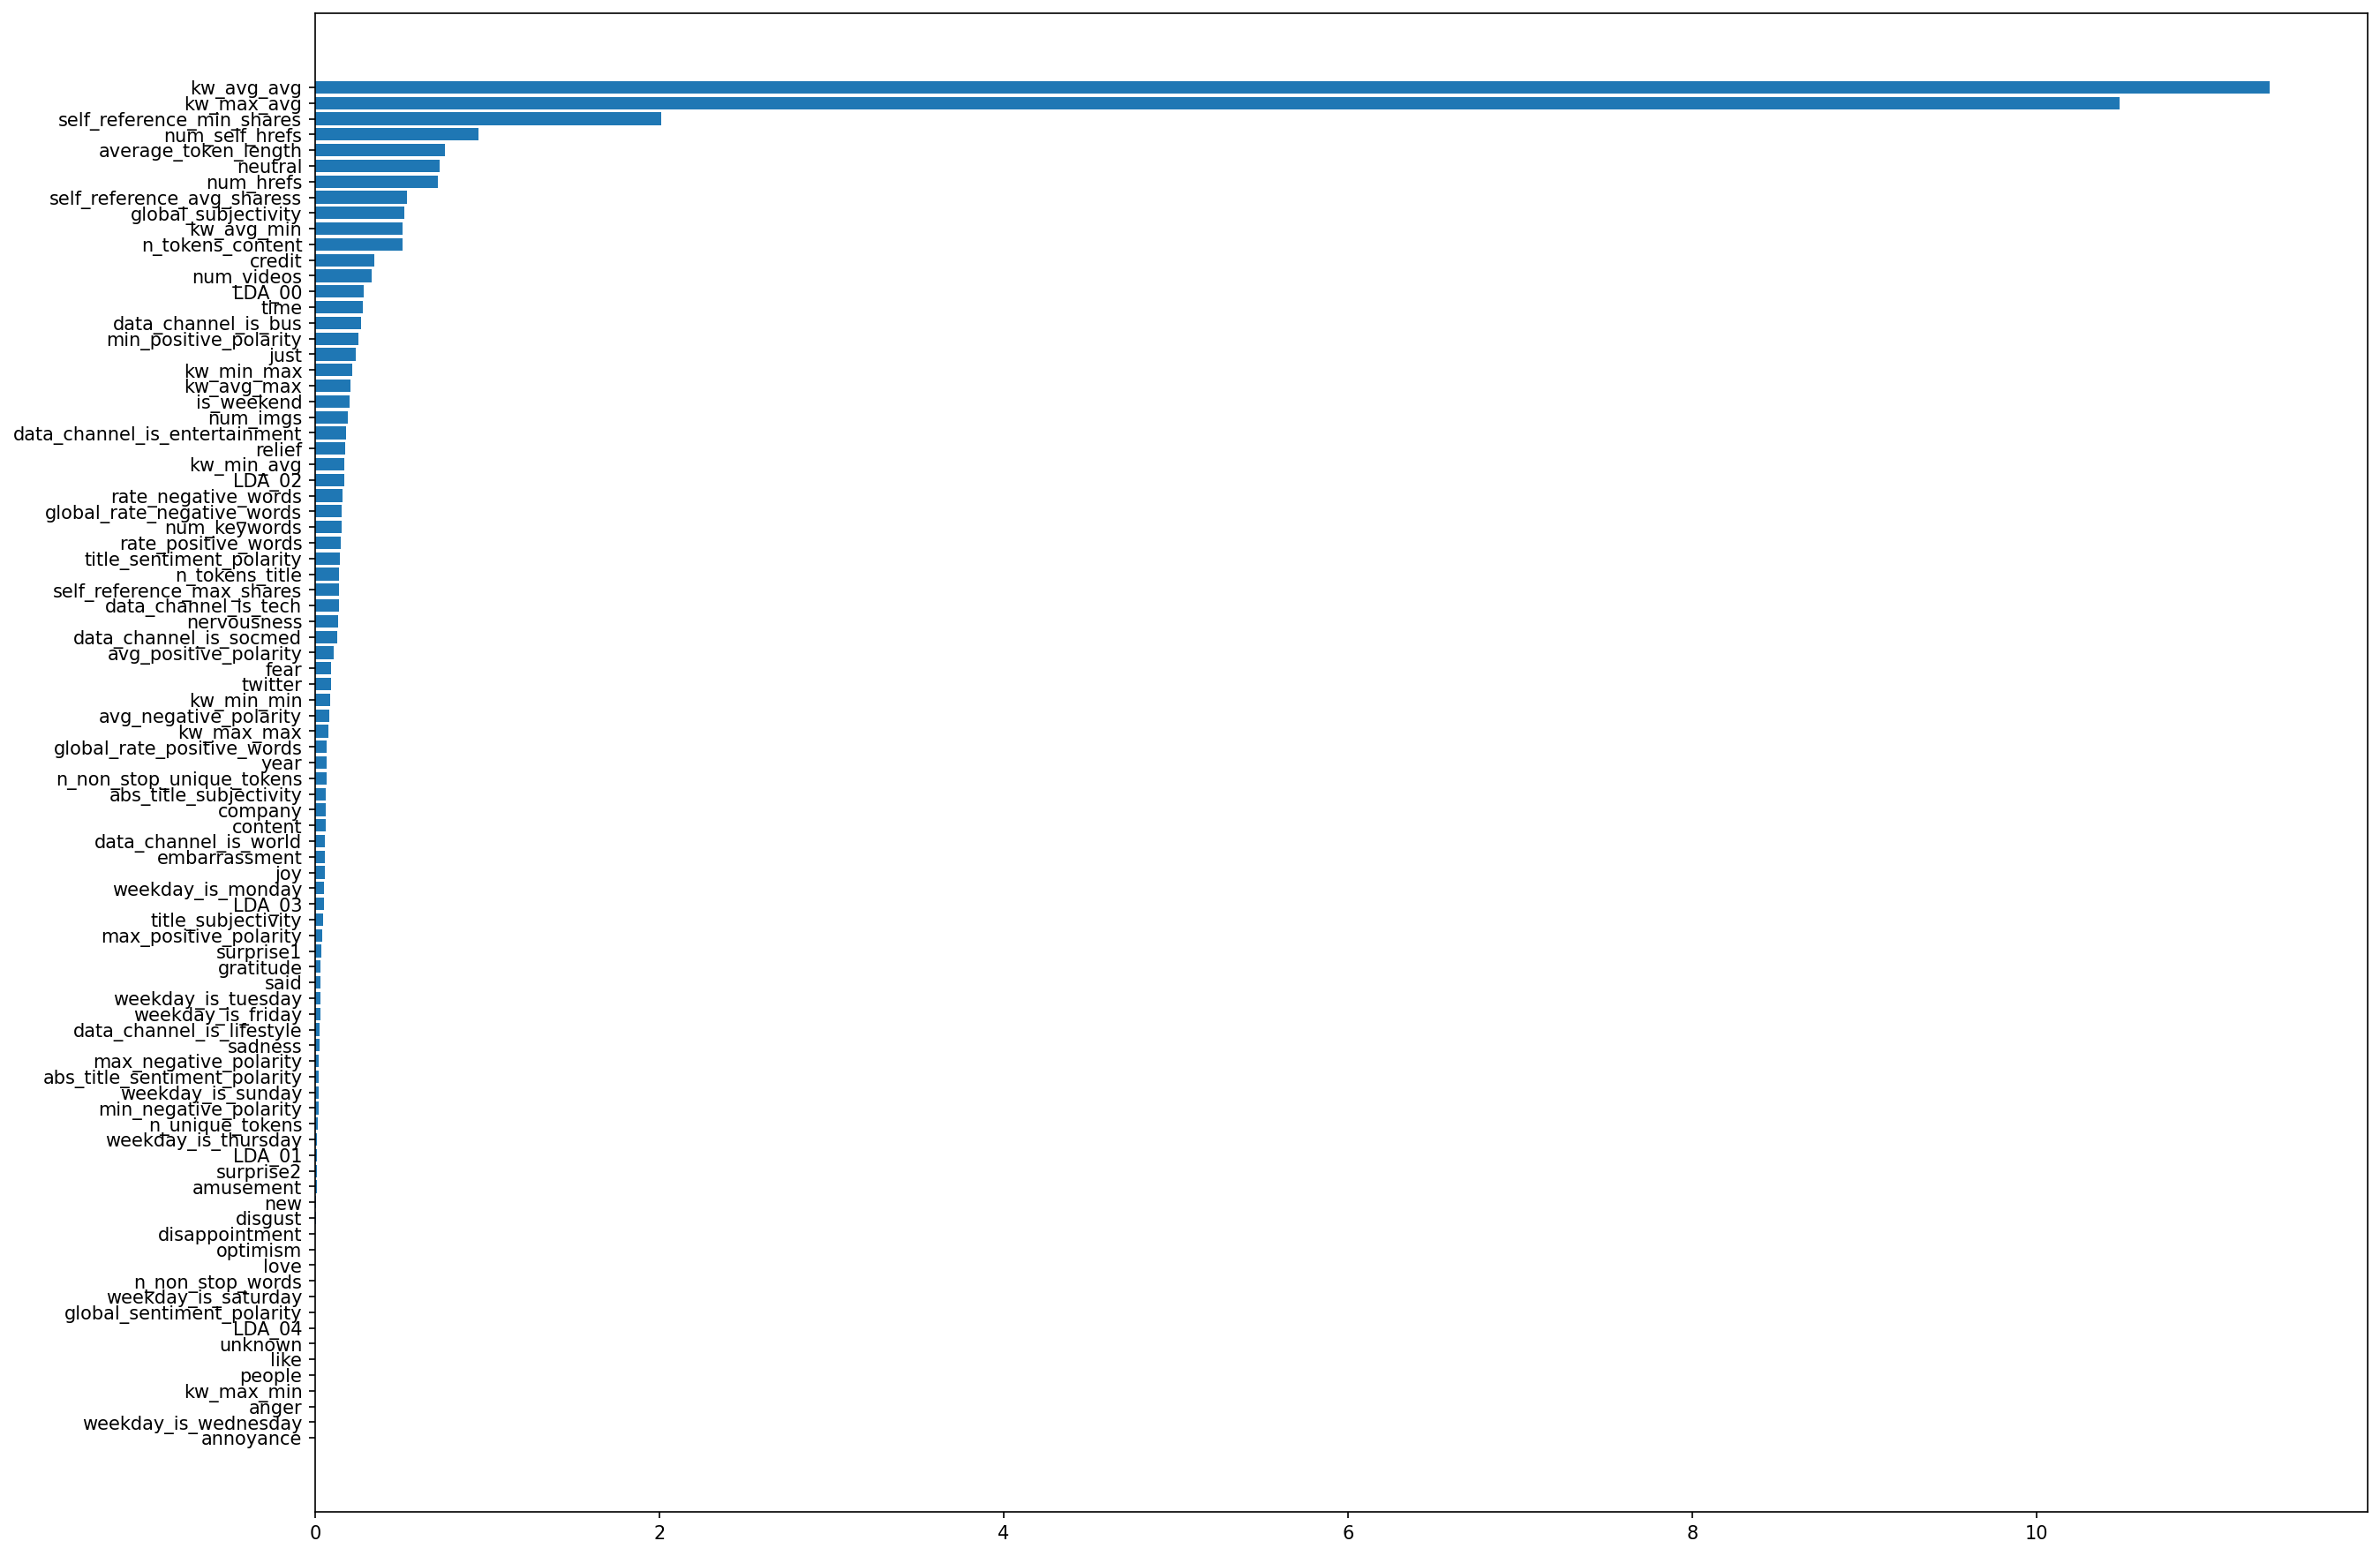

In [ ]:
import matplotlib.pyplot as plt

sorted_idx = abs(logistic_regression_final.coef_[0]).argsort()
x_train.columns[sorted_idx]

plt.figure(dpi=150, figsize=(20, 15))
plt.barh(x_train.columns[sorted_idx], abs(logistic_regression_final.coef_[0])[sorted_idx])

# Test -> Score: 0.7066246056782334

In [ ]:
test = pd.read_parquet('/content/drive/MyDrive/test')

## Feature engineering (aplicando los encodings a test)

### popular

In [ ]:
y_test = test[['popular']]
y_test.popular = encoders['popular'].transform(y_test.popular)

### surprise1

In [ ]:
test['surprise1'] = test['surprise1'].map(surprise1_mean_encoding(test))

### surprise2

In [ ]:
test.surprise2 = test.surprise2.map(lambda x: 'unknown' if x == '' else x)
test.surprise2 = test.surprise2.map(lambda x: x.split(','))
encoded_test_surprise2 = encoders['surprise2'].transform(test.surprise2)
surprise2_test_emotions = pd.DataFrame(encoded_test_surprise2, columns=encoders['surprise2'].classes_)
test.surprise2 = encoded_test_surprise2
test = pd.concat([test.reset_index(), surprise2_test_emotions.reset_index()], axis=1)

### content

In [ ]:
test['content'] = test['content'].fillna('')
vectorized_test_content = encoders['content'].transform(test['content'].tolist()).toarray()
test_content_word_count = pd.DataFrame(vectorized_test_content, columns=encoders['content'].get_feature_names())
test['content'] = vectorized_test_content
test = pd.concat([test.reset_index(), test_content_word_count.reset_index()], axis=1)

### Feature dropping

In [ ]:
if None in features_eliminadas:
    features_eliminadas.remove(None)
for feature_a_droppear in features_eliminadas:
    test.drop(feature_a_droppear, axis=1, inplace=True)

In [ ]:
test.fillna(0.0, inplace=True)

## Modelo contra test -> Score: 0.706625076932212

In [ ]:
logistic_regression_final.fit(scaler.fit_transform(x_train), y_train.popular)
prediction_probabilities = logistic_regression_final.predict_proba(scaler.transform(test))[:,1]
roc_auc_score(y_test.popular, prediction_probabilities)

0.706625076932212

In [ ]:
test_copy = test.copy()
test_copy['popular'] = prediction_probabilities

In [ ]:
test_copy.to_csv('/content/drive/MyDrive/test_con_preds_parte2.csv')

In [ ]:
test_copy_copy = pd.read_csv('/content/drive/MyDrive/test_con_preds_parte2.csv')
test_copy_copy.popular

0       0.343033
1       0.402110
2       0.285806
3       0.437487
4       0.323042
          ...   
3976    0.537554
3977    0.690887
3978    0.642638
3979    0.212375
3980    0.337210
Name: popular, Length: 3981, dtype: float64